In [322]:
#imports
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import sys
sys.path.append('/home1/2064240p/SimonLDA/lda/code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from ldaSingleCell import VariationalLDA
from scipy import spatial
import re
from utilsFuncs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read counts and metadata files
countsAll = pd.read_csv("/data/Alex/COVID19/C145forLDACounts.csv",header=0,index_col=0)

metaAll = pd.read_csv("/data/Alex/COVID19/C145forLDAMeta.csv",header=0,index_col=0)


In [3]:
countsAll.shape

(33539, 11877)

In [4]:
metaAll.head()

,orig.ident,nCount_RNA,nFeature_RNA,group,sample,percent.mt,integrated_snn_res.0.5,seurat_clusters,integrated_snn_res.0.3,pANN_0.25_0.03_1485,DF.classifications_0.25_0.03_1485
AAACCTGAGCTACCGC-1_2_3,SeuratProject,1314,744,Severe COVID-19,C145,3.196347,0,0,0,0.014737,Singlet
AAACCTGAGGAGTAGA-1_2_3,SeuratProject,6290,2003,Severe COVID-19,C145,4.689984,5,5,5,0.328421,Singlet
AAACCTGAGGCCCGTT-1_2_3,SeuratProject,5172,1702,Severe COVID-19,C145,0.580046,0,2,2,0.370526,Singlet
AAACCTGCAAATCCGT-1_2_3,SeuratProject,3333,1254,Severe COVID-19,C145,1.950195,0,0,0,0.149474,Singlet
AAACCTGCAACAACCT-1_2_3,SeuratProject,1376,720,Severe COVID-19,C145,3.488372,0,0,0,0.004211,Singlet


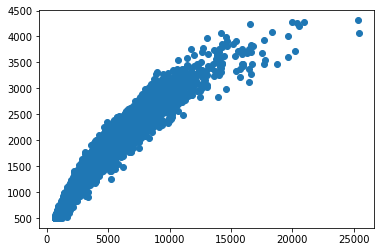

In [5]:
#plot total counts vs number of genes per cell
plt.plot(metaAll['nCount_RNA'],metaAll['nFeature_RNA'],'o')

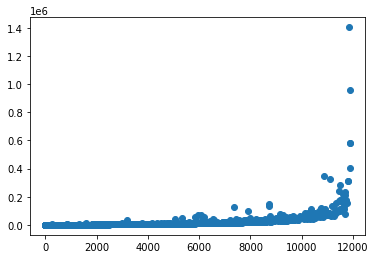

In [6]:
plt.plot(countsAll.astype(bool).sum(axis=1),countsAll.sum(axis=1),'o')

In [7]:
countsAll.shape

(33539, 11877)

In [8]:
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,AAACCTGAGCTACCGC.1_2_3,AAACCTGAGGAGTAGA.1_2_3,AAACCTGAGGCCCGTT.1_2_3,AAACCTGCAAATCCGT.1_2_3,AAACCTGCAACAACCT.1_2_3,AAACCTGCAACTTGAC.1_2_3,AAACCTGCAATGGTCT.1_2_3,AAACCTGCACCTCGTT.1_2_3,AAACCTGCAGGATCGA.1_2_3,AAACCTGCAGTATCTG.1_2_3,...,TTTGTCATCATAAAGG.1_2_3,TTTGTCATCCATGCTC.1_2_3,TTTGTCATCCGCATAA.1_2_3,TTTGTCATCCTAGAAC.1_2_3,TTTGTCATCGTTGACA.1_2_3,TTTGTCATCGTTTGCC.1_2_3,TTTGTCATCTCCTATA.1_2_3,TTTGTCATCTGAAAGA.1_2_3,TTTGTCATCTTTACGT.1_2_3,TTTGTCATCTTTCCTC.1_2_3
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL645608.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
HES4,0,1,0,0,0,0,0,0,1,3,...,0,0,1,1,4,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,0,5,0,0,0,1,2,0,0,4,...,3,0,0,2,0,0,0,0,3,1
MT-CYB,2,17,2,1,2,1,1,1,1,3,...,18,0,1,2,0,1,0,6,6,4
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC240274.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

In [14]:
countsFiltered

,AAACCTGAGCTACCGC.1_2_3,AAACCTGAGGAGTAGA.1_2_3,AAACCTGAGGCCCGTT.1_2_3,AAACCTGCAAATCCGT.1_2_3,AAACCTGCAACAACCT.1_2_3,AAACCTGCAACTTGAC.1_2_3,AAACCTGCAATGGTCT.1_2_3,AAACCTGCACCTCGTT.1_2_3,AAACCTGCAGGATCGA.1_2_3,AAACCTGCAGTATCTG.1_2_3,...,TTTGTCATCATAAAGG.1_2_3,TTTGTCATCCATGCTC.1_2_3,TTTGTCATCCGCATAA.1_2_3,TTTGTCATCCTAGAAC.1_2_3,TTTGTCATCGTTGACA.1_2_3,TTTGTCATCGTTTGCC.1_2_3,TTTGTCATCTCCTATA.1_2_3,TTTGTCATCTGAAAGA.1_2_3,TTTGTCATCTTTACGT.1_2_3,TTTGTCATCTTTCCTC.1_2_3
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL645608.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
HES4,0,1,0,0,0,0,0,0,1,3,...,0,0,1,1,4,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,0,5,0,0,0,1,2,0,0,4,...,3,0,0,2,0,0,0,0,3,1
MT-CYB,2,17,2,1,2,1,1,1,1,3,...,18,0,1,2,0,1,0,6,6,4
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC240274.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RPL22',
 'RPS6KA1',
 'RPA2',
 'RPF1',
 'RPAP2',
 'RPL5',
 'RPRD2',
 'RPS6KC1',
 'RPS7',
 'RPIA',
 'RPL31',
 'RPE',
 'RPL37A',
 'RPUSD3',
 'RPL15',
 'RPSA',
 'RPL14',
 'RPL29',
 'RPP14',
 'RPL24',
 'RPN1',
 'RPL22L1',
 'RPL39L',
 'RPL35A',
 'RPL9',
 'RPS3A',
 'RPL26L1',
 'RPP21',
 'RPS18',
 'RPS10',
 'RPL10A',
 'RPL7L1',
 'RPF2',
 'RPS6KA2',
 'RPA3',
 'RP9',
 'RPS6KA3',
 'RPGR',
 'RP2',
 'RPS4X',
 'RPA4',
 'RPL36A',
 'RPS20',
 'RPL7',
 'RPS6',
 'RPP25L',
 'RPL35',
 'RPL7A',
 'RPL27A',
 'RPS6KA4',
 'RPS6KB2',
 'RPS3',
 'RPS25',
 'RPUSD4',
 'RPP38',
 'RPP30',
 'RPAP3',
 'RPL6',
 'RPLP0',
 'RPL21',
 'RPS29',
 'RPL36AL',
 'RPS6KA5',
 'RPAP1',
 'RPS27L',
 'RPL4',
 'RPP25',
 'RPS17',
 'RPUSD1',
 'RPS2',
 'RPL13',
 'RPA1',
 'RPAIN',
 'RPL26',
 'RPL23A',
 'RPL23',
 'RPL27',
 'RPS6KB1',
 'RPL38',
 'RPTOR',
 'RPRD1A',
 'RPL17',
 'RPN2',
 'RPRD1B',
 'RPL18A',
 'RPS16',
 'RPL18',
 'RPL13A',
 'RPS11',
 'RPS9',
 'RPS5',
 'RPS4Y1',
 'RPL3',
 'RPS19BP1']

In [16]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [17]:
#select clusters for reference + to be singlets
referenceCells = metaAll[metaAll['seurat_clusters'].isin([0,1,2,3,4,5,6,7,8,10,11])]
referenceCells = referenceCells[referenceCells['DF.classifications_0.25_0.03_1485']=='Singlet']


In [18]:
referenceCells.shape

(10332, 11)

In [19]:
referenceCells.index = [i.replace("-",".") for i in referenceCells.index]

In [20]:
countsFiltered.T

,LINC00115,NOC2L,PLEKHN1,AL645608.8,HES4,AGRN,C1orf159,TNFRSF18,TNFRSF4,SDF4,...,PRMT2,MT-ATP8,MT-ATP6,MT-ND4L,MT-ND5,MT-ND6,MT-CYB,AC004556.1,AC240274.1,nCoV
AAACCTGAGCTACCGC.1_2_3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,0,0,0
AAACCTGAGGAGTAGA.1_2_3,0,0,0,0,1,0,0,0,0,3,...,0,13,4,16,14,5,17,0,0,0
AAACCTGAGGCCCGTT.1_2_3,0,0,0,0,0,0,0,0,0,1,...,2,2,0,2,1,0,2,0,0,0
AAACCTGCAAATCCGT.1_2_3,0,1,0,0,0,0,0,0,0,1,...,0,2,1,2,4,0,1,0,0,0
AAACCTGCAACAACCT.1_2_3,0,0,0,0,0,0,0,0,0,0,...,0,1,6,1,2,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGTTTGCC.1_2_3,0,1,0,0,0,0,0,0,0,0,...,0,3,4,3,2,0,1,0,0,0
TTTGTCATCTCCTATA.1_2_3,0,0,0,0,0,0,0,0,0,0,...,0,0,4,1,1,0,0,0,0,0
TTTGTCATCTGAAAGA.1_2_3,0,0,0,0,3,0,0,0,0,1,...,1,3,4,10,7,0,6,0,0,0
TTTGTCATCTTTACGT.1_2_3,0,0,0,0,0,0,0,0,0,1,...,0,6,4,1,5,3,6,0,0,0


In [21]:
referenceCounts = countsFiltered[referenceCells.index]

In [22]:
#select cluster for doublets
doubletsCells = metaAll[metaAll['seurat_clusters']==9]
doubletsCells.index = [i.replace("-",".") for i in doubletsCells.index]

In [23]:
doubletsCells.shape

(221, 11)

In [24]:
doubletsCounts = countsFiltered[doubletsCells.index]
doubletsCounts.shape

(10082, 221)

In [34]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 50,alpha = 1,eta=0.0005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 92.2854215812531) (663.0200000000004 seconds, I think I'll finish in 552.516666666667 minutes). Alpha: (5.764507355212702,12.191011103810377)
Iteration 1 (change = 0.05156130032617339) (591.7299999999996 seconds, I think I'll finish in 483.2461666666663 minutes). Alpha: (9.0891378888563,19.90193512114837)
Iteration 2 (change = 0.043354735784137795) (599.3100000000013 seconds, I think I'll finish in 479.44800000000106 minutes). Alpha: (11.474519396947326,25.410298029305793)
Iteration 3 (change = 0.038900948250832235) (586.619999999999 seconds, I think I'll finish in 459.5189999999992 minutes). Alpha: (13.183886658382194,29.35133495163505)
Iteration 4 (change = 0.03604899642420442) (587.3199999999997 seconds, I think I'll finish in 450.2786666666664 minutes). Alpha: (14.411205775041125,32.178849579024615)
Iteration 5 (change = 0.034089107232202855) (581.7200000000012 seconds, I think I'll finish in 436.2900000000009 minutes). Alpha: (15.294403125645276,34.2123845362

In [28]:
# singleCellLDA2 = VariationalLDA(K = 30,alpha = 1,eta=0.005,update_alpha=True)
# singleCellLDA2.load_data_sc(referenceCounts)
# singleCellLDA2.run_vb(n_its = 5,initialise=True)

# singleCellLDA3 = VariationalLDA(K = 70,alpha = 1,eta=0.005,update_alpha=True)
# singleCellLDA3.load_data_sc(referenceCounts)
# # singleCellLDA3.run_vb(n_its = 5,initialise=True)

Edited
Initialising
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 47.15649583592806) (597.3899999999994 seconds, I think I'll finish in 49.78249999999995 minutes). Alpha: (11.157348783211145,18.218365002113554)
Iteration 1 (change = 0.11377823417251944) (550.380000000001 seconds, I think I'll finish in 36.69200000000007 minutes). Alpha: (16.417171816572527,27.027462511502513)
Iteration 2 (change = 0.10485925019512586) (550.539999999999 seconds, I think I'll finish in 27.52699999999995 minutes). Alpha: (20.18078914107452,33.276089648227504)
Iteration 3 (change = 0.09673562447878252) (554.5900000000001 seconds, I think I'll finish in 18.486333333333338 minutes). Alpha: (22.9004745302899,37.74505376403514)
Iteration 4 (change = 0.09105802057690045) (554.6599999999999 seconds, I think I'll finish in 9.244333333333332 minutes). Alpha: (24.847506296909017,40.90033131406406)


In [29]:
from scipy.spatial.distance import cosine
from itertools import combinations

def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

In [33]:
print(averageDistance(singleCellLDA))
print (averageDistance(singleCellLDA2))
print (averageDistance(singleCellLDA3))

0.0005785282044027074
0.004792163993192117
0.004711511148202249


In [35]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [36]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 10332 documents


In [37]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [38]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [39]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 33.609101641420324) (26.160000000003492 seconds, I think I'll finish in 43.60000000000582 minutes). Alpha: (1.014361951582645,25.102928612185202)
Iteration 1 (change = 6.582487470452048) (24.209999999999127 seconds, I think I'll finish in 39.94649999999856 minutes). Alpha: (1.1146470918393065,41.709820711454846)
Iteration 2 (change = 4.844442902981978) (24.2300000000032 seconds, I think I'll finish in 39.57566666667189 minutes). Alpha: (1.1948020141441336,53.97326178163166)
Iteration 3 (change = 4.716688102704421) (23.540000000000873 seconds, I think I'll finish in 38.05633333333474 minutes). Alpha: (1.2635981015470554,63.302682988306096)
Iteration 4 (change = 5.645198522107323) (23.339999999996508 seconds, I think I'll finish in 37.34399999999441 minutes). Alpha: (1.343327745780742,70.31120418890931)
Iteration 5 (change = 6.98165030217395) (23.650000000001455 seconds, I think I'll finish in 37.445833333335635 minutes). Alpha: (1.45122853998724,75.16009737294604)


Iteration 49 (change = 0.7277478473688905) (23.790000000000873 seconds, I think I'll finish in 20.22150000000074 minutes). Alpha: (0.026150046198820765,1.5116600471116675)
Iteration 50 (change = 0.6889462354650803) (23.74000000000524 seconds, I think I'll finish in 19.783333333337698 minutes). Alpha: (0.024567040465878907,1.4479294015007802)
Iteration 51 (change = 0.6536334377373664) (23.409999999996217 seconds, I think I'll finish in 19.118166666663576 minutes). Alpha: (0.02310272662603607,1.389147283174084)
Iteration 52 (change = 0.6223708578022581) (23.37999999999738 seconds, I think I'll finish in 18.703999999997905 minutes). Alpha: (0.02180760593554692,1.3348532063362497)
Iteration 53 (change = 0.5947587765718967) (22.9800000000032 seconds, I think I'll finish in 18.00100000000251 minutes). Alpha: (0.020664503362138358,1.2845602180801405)
Iteration 54 (change = 0.5694087879052652) (23.30999999999767 seconds, I think I'll finish in 17.870999999998215 minutes). Alpha: (0.01964636716

Iteration 97 (change = 0.16778272743811404) (23.2699999999968 seconds, I think I'll finish in 1.1634999999998399 minutes). Alpha: (0.005822598259172879,0.38374015102452336)
Iteration 98 (change = 0.16469019166124735) (22.950000000004366 seconds, I think I'll finish in 0.7650000000001456 minutes). Alpha: (0.005717403602772486,0.37469119048545707)
Iteration 99 (change = 0.16160271740016469) (22.849999999998545 seconds, I think I'll finish in 0.3808333333333091 minutes). Alpha: (0.005616272892255231,0.3659161155698929)


In [40]:
scLDA.beta_matrix.shape

(80, 10082)

In [41]:
scLDA.get_expect_theta().shape

(221, 80)

In [195]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)

In [204]:
wordTopicNew.T[52].sort_values(ascending=False)[0:10]

PPIA        0.003835
CCL5        0.003694
S100A4      0.003615
MT-ND4L     0.002906
SUB1        0.002408
CEBPB       0.002382
CCL8        0.002237
HLA-DRB5    0.002133
GZMB        0.002099
MT-CYB      0.002095
Name: 52, dtype: float64

In [264]:
doubletsCounts.shape

(10082, 221)

In [323]:
interesting_genes = ranking_genes(50,80,scLDA, doubletsCounts.index)

In [309]:
interesting_genes.sort_values(1,ascending=False)[60:70]

,0,1,2
381,PTPRC,17,0.0904255
3497,CCL5,17,0.10559
966,PLSCR1,17,0.085
323,CD48,17,0.115646
3426,XAF1,17,0.0858586
2385,PTPRCAP,17,0.140496
1378,PRELID1,17,0.114865
199,GBP5,17,0.116438
3080,NFKBIA,17,0.0825243
2252,RHOG,17,0.115646


In [ ]:
refC = referenceCounts.T.merge(referenceCells,left_index=True,right_index=True)
refC = refC.sort_values(by="seurat_clusters")
refC = refC.drop(referenceCells.columns, axis=1)
allCounts = pd.merge(refC.T,doubletsCounts,left_index=True,right_index=True)
colours = ['blue' if x in refC.index else "red" for x in allCounts.columns]
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=allCounts.index)

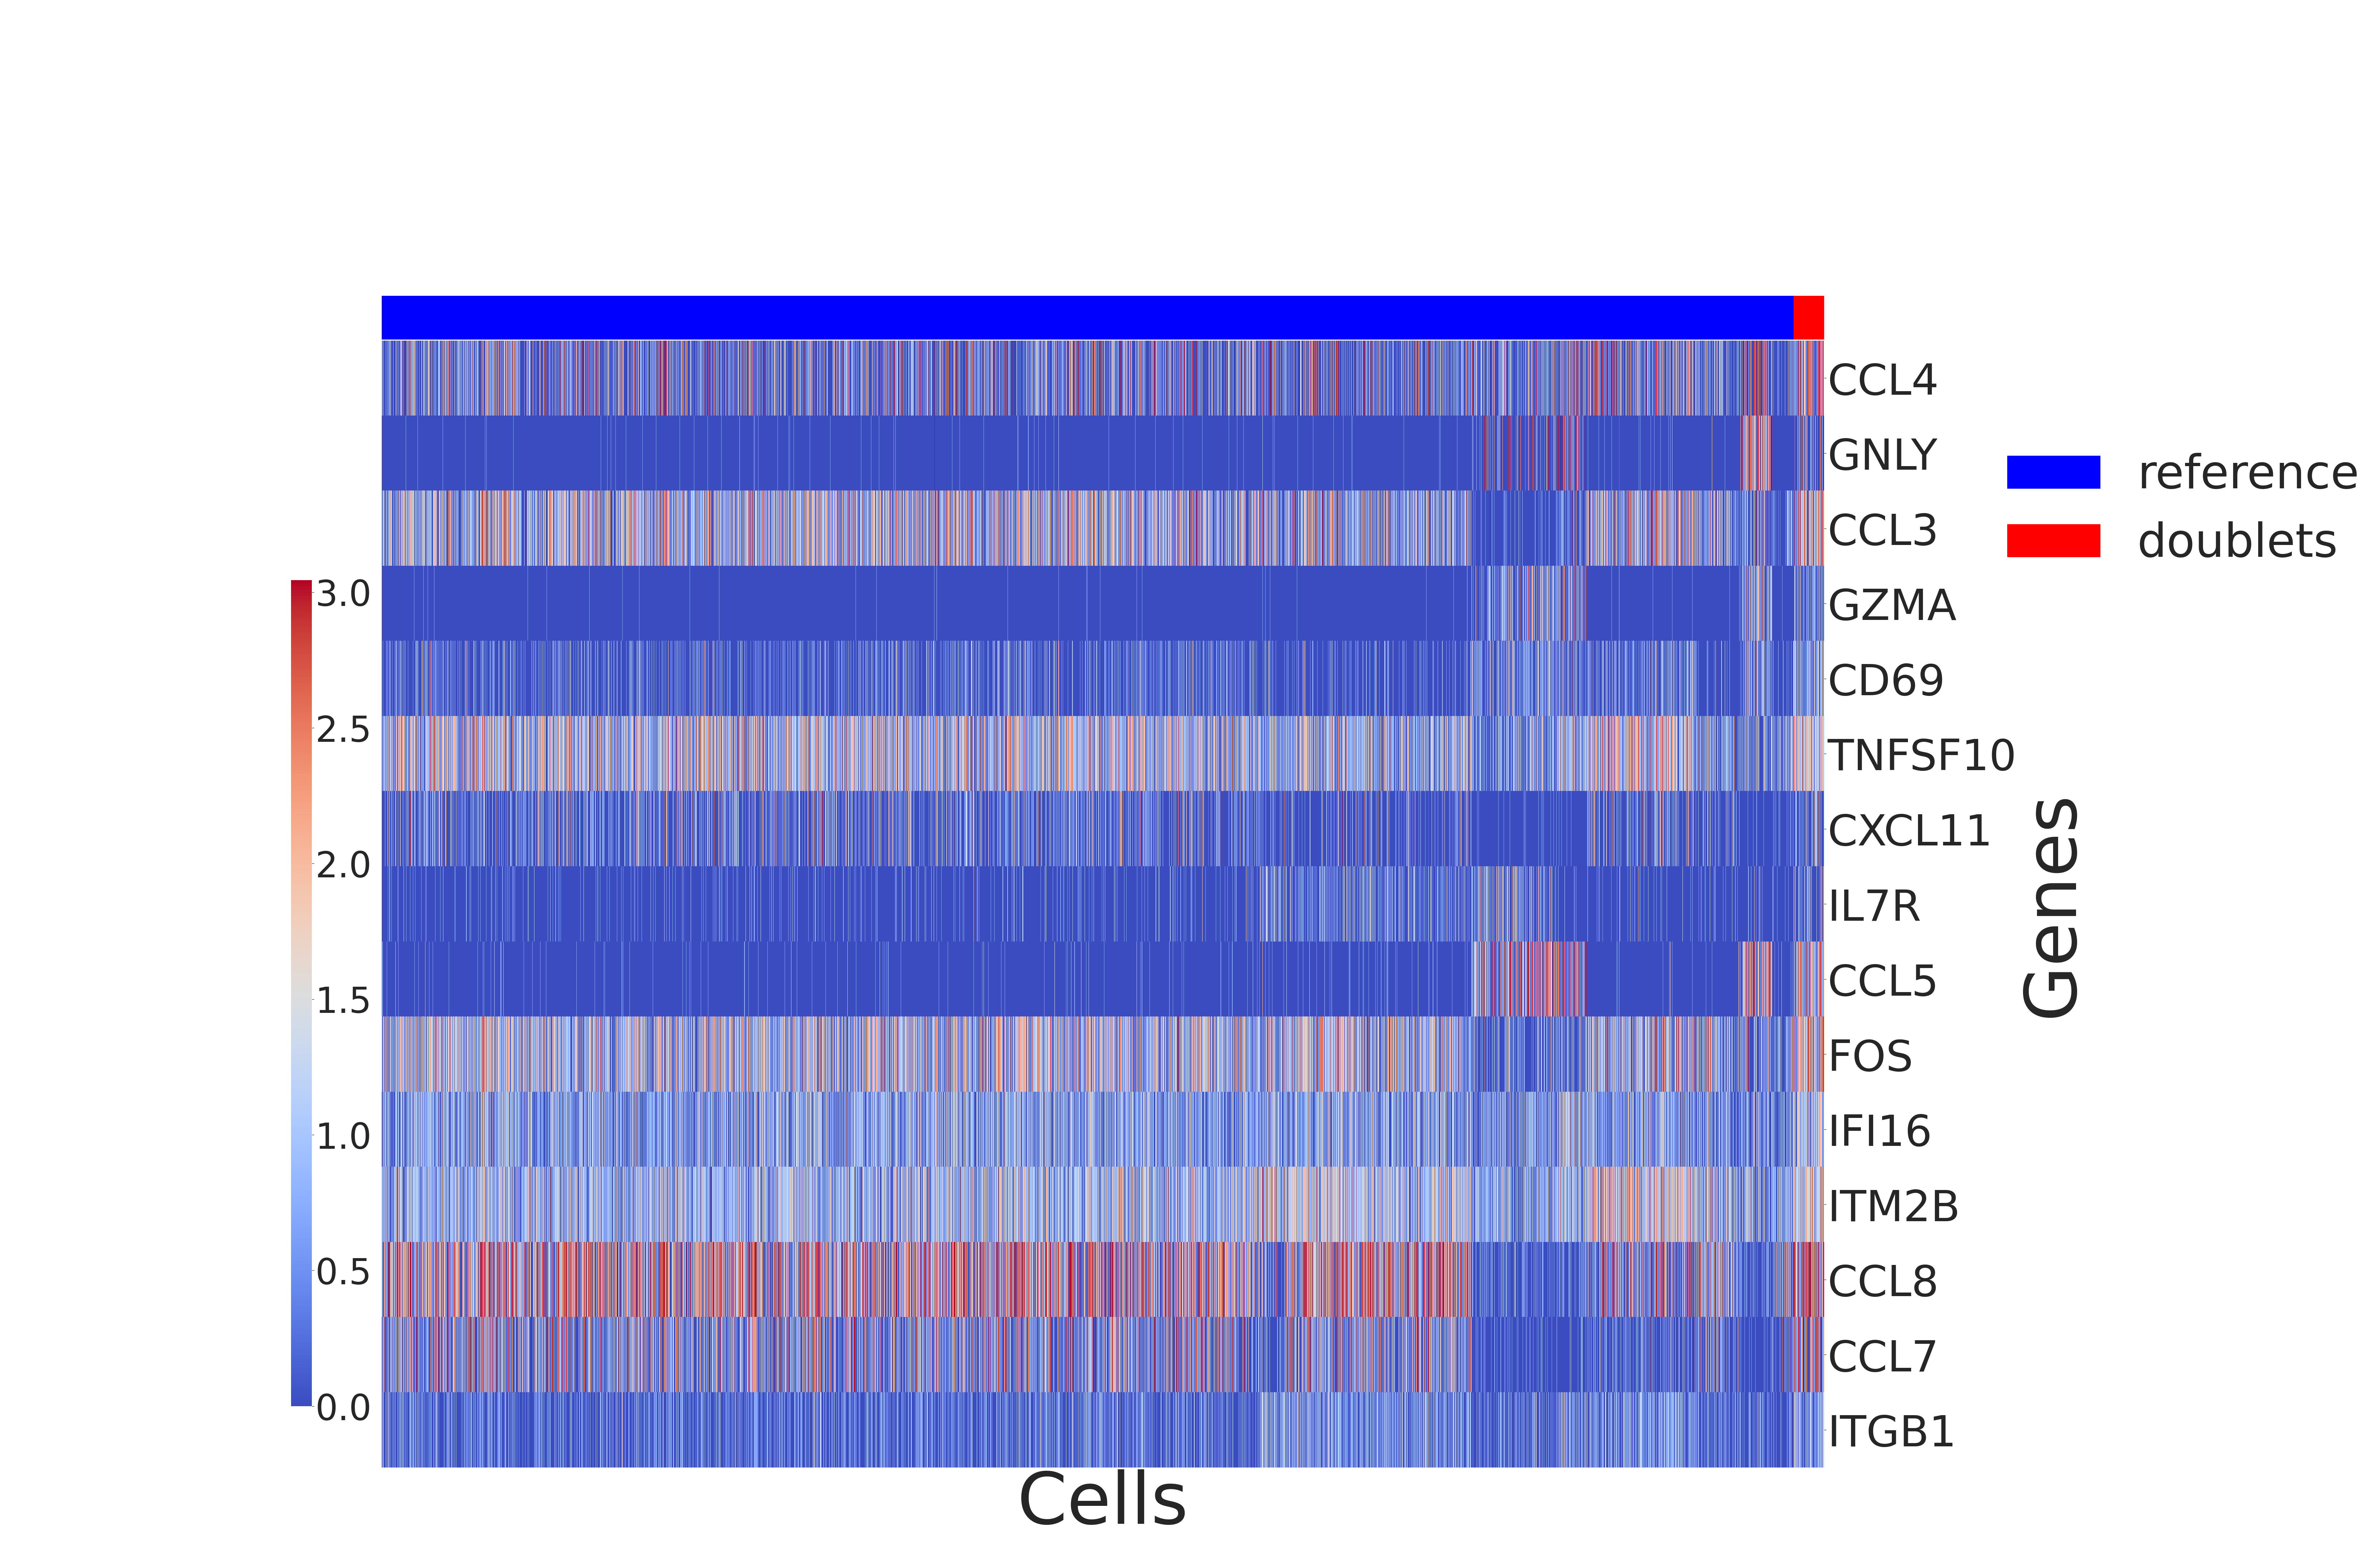

In [313]:
from matplotlib.transforms import Bbox
sb.set(font_scale=9)
blue_ref = mpatches.Patch(color="blue", label="reference")
red_dbls = mpatches.Patch(color="red", label="doublets")
legend_TN = [blue_ref, red_dbls]
heatmapCV = sb.clustermap(np.log1p(allCounts.loc[["CCL4","GNLY","CCL3","GZMA","CD69","TNFSF10","CXCL11","IL7R","CCL5",
                                                  "FOS","IFI16","ITM2B","CCL8","CCL7","ITGB1"]]),row_cluster=False, col_cluster=False, 
               figsize=(80,80),robust=True,cmap='coolwarm',col_colors = colours)

heatmapCV.ax_heatmap.set_xticks([])
heatmapCV.ax_heatmap.set_yticklabels(heatmapCV.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmapCV.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmapCV.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmapCV.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.40,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
heatmapCV.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.savefig("Covid_LDA_res2021.png",dpi=100,bbox_inches="tight")